In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

# Movie Recommender

## 1. Load data

In [2]:
df_movies = pd.read_csv("ml-latest-small/movies.csv")
df_ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Time stamp is seconds after 19:17 january first (unix epoch time)

In [5]:
df_movies = df_movies.drop(columns = "genres")
df_ratings = df_ratings.drop(columns = "timestamp")

In [6]:
df_movies.shape

(9742, 2)

In [7]:
df_ratings["userId"].nunique()

610

# 2. Create feature set

based on user ratings for a movie

Dataset design:

|movieId|user1|user2|user3|...|
|-------|-----|-----|-----|---|
|1      | 0   |  2  | 4   |...|
|2      | 5   |  5  | 0   |...|
|...    |...  |...  | ... |...|


First, however, we need to filter movies with almost no ratings. Those may not yield meaningful recommendations

In [8]:
df = df_movies.merge(df_ratings, how = "left", on="movieId")

In [9]:
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1.0,4.0
1,1,Toy Story (1995),5.0,4.0
2,1,Toy Story (1995),7.0,4.5
3,1,Toy Story (1995),15.0,2.5
4,1,Toy Story (1995),17.0,4.5


Calculate no_of_ratings for each movie

In [10]:
df_no_of_ratings = (df_ratings
                    .groupby("movieId")
                    .agg({"userId" : "count"})
                    .rename(columns ={"userId": "no_of_ratings"})
                    .reset_index())

In [11]:
df = df.merge(df_no_of_ratings, how = "left", on = "movieId")

In [12]:
df.head()

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215.0
1,1,Toy Story (1995),5.0,4.0,215.0
2,1,Toy Story (1995),7.0,4.5,215.0
3,1,Toy Story (1995),15.0,2.5,215.0
4,1,Toy Story (1995),17.0,4.5,215.0


## 2.1 Filter movies with no of ratings below a certain threshold

Plot histogram (distribution)

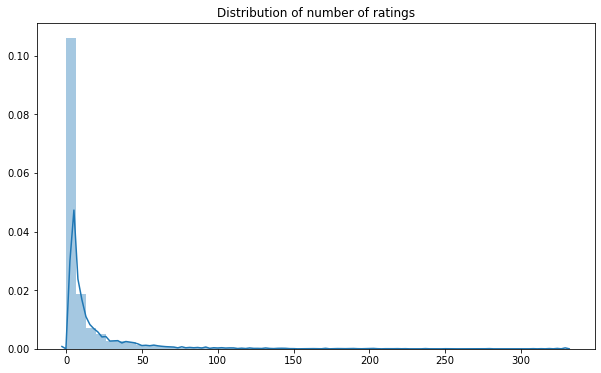

In [13]:
fig = plt.figure(figsize = (10, 6))
sns.distplot(df.groupby("movieId").agg({"userId": "count"}));
plt.title("Distribution of number of ratings");

In [14]:
df_no_of_ratings.describe()

,movieId,no_of_ratings
count,9724.000000,9724.000000
mean,42245.024373,10.369807
std,52191.137320,22.401005
min,1.000000,1.000000
25%,3245.500000,1.000000
50%,7300.000000,3.000000
75%,76739.250000,9.000000
max,193609.000000,329.000000


Set lower threshold for no_of_rating to be considered for recommendations

In [15]:
min_no_of_ratings = 5
movies = df[df["no_of_ratings"] >= 5].copy()

In [16]:
movies.head()

,movieId,title,userId,rating,no_of_ratings
0,1,Toy Story (1995),1.0,4.0,215.0
1,1,Toy Story (1995),5.0,4.0,215.0
2,1,Toy Story (1995),7.0,4.5,215.0
3,1,Toy Story (1995),15.0,2.5,215.0
4,1,Toy Story (1995),17.0,4.5,215.0


In [17]:
movies["movieId"].nunique()

3650

In [18]:
movie_features = movies.pivot_table(index = "movieId",
                                    columns = "userId",
                                    values = "rating").fillna(0)

# 3. Modeling

In [19]:
from scipy.sparse import csr_matrix

#dataframes are really heavy. A more eficient way is using csr_matrix

In [20]:
mat_movie_features = csr_matrix(movie_features)

## 3.1 Train KNN

k-Nearest-Neighbors

In [21]:
# calculate the angule between each one of the movies.
# with this we train our model

model_knn = NearestNeighbors(metric = "cosine",
                            algorithm = "brute",
                            n_jobs = -1)

model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [22]:
# now we need to pass a vector, so the algorithm can calculate the movies that are closest to this vector

movie_features.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,601.0,602.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#vector with one dimention array:
movie_features.loc[1].values

array([4. , 0. , 0. , 0. , 4. , 0. , 4.5, 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 2.5, 0. , 4.5, 3.5, 4. , 0. , 3.5, 0. , 0. , 0. , 0. , 0. ,
       3. , 0. , 0. , 0. , 5. , 3. , 3. , 0. , 0. , 0. , 0. , 0. , 0. ,
       5. , 0. , 0. , 5. , 3. , 4. , 5. , 0. , 0. , 0. , 3. , 0. , 0. ,
       0. , 3. , 0. , 0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 0. ,
       4. , 0. , 2.5, 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0.5, 0. , 4. ,
       0. , 0. , 0. , 2.5, 0. , 0. , 0. , 4. , 0. , 0. , 3. , 3. , 4. ,
       0. , 3. , 0. , 0. , 5. , 0. , 4.5, 0. , 0. , 0. , 0. , 4. , 0. ,
       0. , 0. , 4. , 0. , 0. , 0. , 0. , 3. , 0. , 0. , 0. , 0. , 0. ,
       0. , 3.5, 0. , 4. , 0. , 0. , 4. , 0. , 0. , 0. , 0. , 0. , 3. ,
       0. , 2. , 0. , 3. , 4. , 0. , 4. , 0. , 0. , 3. , 4. , 0. , 0. ,
       3.5, 5. , 0. , 0. , 0. , 0. , 0. , 5. , 0. , 2. , 0. , 3. , 4. ,
       0. , 0. , 4.5, 4. , 4. , 0. , 0. , 0. , 0. , 5. , 3.5, 0. , 4.5,
       0. , 5. , 0. , 0. , 0. , 0. , 0. , 5. , 4. , 4. , 0. , 0.

In [24]:
#given the vector, give me the nearest 6 neighbor (the first will be the vector itself)

model_knn.kneighbors(movie_features.loc[1], n_neighbors = 6)

ValueError: Expected 2D array, got 1D array instead:
array=[4.  0.  0.  0.  4.  0.  4.5 0.  0.  0.  0.  0.  0.  0.  2.5 0.  4.5 3.5
 4.  0.  3.5 0.  0.  0.  0.  0.  3.  0.  0.  0.  5.  3.  3.  0.  0.  0.
 0.  0.  0.  5.  0.  0.  5.  3.  4.  5.  0.  0.  0.  3.  0.  0.  0.  3.
 0.  0.  5.  0.  0.  0.  0.  0.  5.  4.  0.  4.  0.  2.5 0.  0.  5.  0.
 4.5 0.  0.  0.5 0.  4.  0.  0.  0.  2.5 0.  0.  0.  4.  0.  0.  3.  3.
 4.  0.  3.  0.  0.  5.  0.  4.5 0.  0.  0.  0.  4.  0.  0.  0.  4.  0.
 0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  3.5 0.  4.  0.  0.  4.  0.  0.
 0.  0.  0.  3.  0.  2.  0.  3.  4.  0.  4.  0.  0.  3.  4.  0.  0.  3.5
 5.  0.  0.  0.  0.  0.  5.  0.  2.  0.  3.  4.  0.  0.  4.5 4.  4.  0.
 0.  0.  0.  5.  3.5 0.  4.5 0.  5.  0.  0.  0.  0.  0.  5.  4.  4.  0.
 0.  4.  0.  0.  4.  4.  0.  0.  0.  0.  4.  0.  2.  0.  0.  0.  0.  0.
 0.  3.5 5.  4.  0.  0.  0.  5.  0.  0.  0.  0.  0.  0.  3.5 3.  0.  3.
 4.  0.  3.5 5.  0.  0.  3.5 0.  0.  3.5 0.  0.  5.  0.  0.  3.5 3.  5.
 0.  0.  0.  0.  4.  5.  0.  0.  0.  0.  0.  0.  5.  0.  4.  0.  0.  4.5
 0.  4.5 0.  0.  0.  0.  0.  0.  0.  0.  4.  4.  0.  2.  0.  0.  5.  5.
 0.  0.  5.  4.  5.  4.  4.  0.  3.  4.5 0.  4.5 3.  0.  0.  0.  0.  4.5
 0.  4.  4.  4.  3.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  5.  0.  0.
 4.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  3.5 3.5 0.
 0.  0.  0.  5.  0.  4.  0.  4.  0.  3.5 0.  4.  4.  0.  4.  0.  5.  0.
 0.  0.  0.  0.  5.  0.  0.  4.  0.  0.  5.  0.  0.  0.  5.  0.  4.  0.
 0.  0.  0.  5.  0.  0.  5.  0.  0.  0.  0.  3.  3.  0.  0.  0.  0.  4.5
 0.  5.  3.5 4.5 0.  0.  4.  0.  0.  0.  5.  0.  3.  0.  0.  0.  0.  5.
 0.  0.  4.  0.  3.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  2.  0.  4.
 0.  0.  0.  0.  0.  4.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.5
 0.  4.  0.  4.  0.  4.5 0.  0.  0.  0.  4.  0.  0.  0.  0.  5.  0.  0.
 5.  0.  5.  0.  0.  5.  0.  0.  0.  4.5 0.  1.5 0.  0.  0.  0.  0.  4.
 4.  4.  5.  0.  0.  4.  0.  4.  4.  0.  0.  3.  0.  0.  4.  4.5 0.  0.
 0.  4.5 0.  3.5 0.  4.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  4.
 0.  0.  0.  0.  4.  0.  0.  0.  0.  4.  0.  0.  4.  0.  0.  0.  0.  3.
 0.  4.  4.  0.  0.  2.5 3.  0.  0.  0.  5.  4.  0.  0.  0.  0.  0.  0.
 3.  0.  0.  3.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  4.  0.  0.  0.
 5.  3.  4.  4.5 0.  0.  0.  0.  3.5 0.  0.  4.  0.  4.  5.  0.  0.  0.
 0.  0.  4.  3.  0.  0.  0.  5.  0.  0.  5.  0.  0.  4.  0.  0.  0.  0.
 0.  4.  4.  0.  3.  2.5 4.  0.  4.  3.  4.  2.5 4.  2.5 3.  5. ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# we need to reshape, as informed in the error message
movie_features.loc[1].values.reshape(1, -1);

In [25]:
# be carefull, it return the index and because of this we need to use iloc when looking for the movide recomended

model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors = 6)

(array([[0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
         0.45290409]]),
 array([[   0, 1545,  306,  429,  169,  231]], dtype=int64))

In [26]:
# movie with name 3114

movie_features.iloc[1545]

userId
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    0.0
607.0    3.0
608.0    2.5
609.0    0.0
610.0    5.0
Name: 3114, Length: 610, dtype: float64

In [27]:
df_movies[df_movies["movieId"] == 3114]

,movieId,title
2355,3114,Toy Story 2 (1999)


In [28]:
movie_features.iloc[306]

userId
1.0      4.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    2.5
607.0    4.0
608.0    3.0
609.0    3.0
610.0    5.0
Name: 480, Length: 610, dtype: float64

In [29]:
df_movies[df_movies["movieId"] == 480]

,movieId,title
418,480,Jurassic Park (1993)


In [30]:
movie_features.iloc[429]

userId
1.0      3.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    2.5
607.0    4.0
608.0    3.0
609.0    0.0
610.0    3.5
Name: 780, Length: 610, dtype: float64

In [31]:
df_movies[df_movies["movieId"] == 780]

,movieId,title
615,780,Independence Day (a.k.a. ID4) (1996)


In [32]:
df_movies[df_movies["title"].str.contains("Poulain")]

,movieId,title
3622,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."


In [33]:
model_knn.kneighbors(movie_features.loc[4973].values.reshape(1, -1), n_neighbors = 6)

(array([[0.        , 0.41176525, 0.4493088 , 0.45401329, 0.48785009,
         0.49474865]]),
 array([[2099, 2498, 1472, 1941, 1348, 1172]], dtype=int64))

In [34]:
movie_features.iloc[2498]

userId
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
5.0      0.0
        ... 
606.0    4.0
607.0    0.0
608.0    4.5
609.0    0.0
610.0    5.0
Name: 7361, Length: 610, dtype: float64

In [35]:
df_movies[df_movies["movieId"] == 7361]

,movieId,title
4909,7361,Eternal Sunshine of the Spotless Mind (2004)


In [36]:
movie_features.iloc[1472]

userId
1.0      5.0
2.0      0.0
3.0      0.0
4.0      2.0
5.0      0.0
        ... 
606.0    5.0
607.0    0.0
608.0    5.0
609.0    0.0
610.0    5.0
Name: 2959, Length: 610, dtype: float64

In [37]:
df_movies[df_movies["movieId"] == 2959]

,movieId,title
2226,2959,Fight Club (1999)


In [38]:
movie_features.iloc[1941]

userId
1.0      0.0
2.0      0.0
3.0      0.0
4.0      2.0
5.0      0.0
        ... 
606.0    4.0
607.0    0.0
608.0    4.5
609.0    0.0
610.0    5.0
Name: 4226, Length: 610, dtype: float64

In [39]:
df_movies[df_movies["movieId"] == 4226]

,movieId,title
3141,4226,Memento (2000)


Our KNN model returns a tuple two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the result with movieId or titles, we need to translate the output. 

# 4. Making our recommender more user-friendly

## 4.1. Translating recommendations to titles

In [40]:
distances, indeces = model_knn.kneighbors(movie_features.loc[1].values.reshape(1, -1), n_neighbors = 6)

In [41]:
indeces

array([[   0, 1545,  306,  429,  169,  231]], dtype=int64)

The `indeces` array contains the positional indeces of the movies in the initial dataset used for training (`movie_features`).

#### Create a mapping between movieId and Titel

In [42]:
movie_list = movies[["movieId", "title"]].drop_duplicates().set_index("movieId")

In [43]:
movie_list

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)
...,...
180031,The Shape of Water (2017)
180985,The Greatest Showman (2017)
183897,Isle of Dogs (2018)


In [44]:
movie_list.iloc[0, 0]

'Toy Story (1995)'

In [45]:
# indeces is a list inside a list, for this reason need to be flatten.

j = 0

for i in indeces.flatten():
    movie = movie_list.iloc[i, 0]
    if j == 0:
        print(f"Recommendations for {movie}:")
        print("--------------------------------\n")
    else:
        print(f"{j}: {movie}")
    j += 1
        
    

Recommendations for Toy Story (1995):
--------------------------------

1: Toy Story 2 (1999)
2: Jurassic Park (1993)
3: Independence Day (a.k.a. ID4) (1996)
4: Star Wars: Episode IV - A New Hope (1977)
5: Forrest Gump (1994)


In [46]:
indeces.flatten()

array([   0, 1545,  306,  429,  169,  231], dtype=int64)

In [47]:
distances.flatten()

array([0.        , 0.42739874, 0.4343632 , 0.43573831, 0.44261183,
       0.45290409])

In [48]:
list(zip(indeces.flatten(), distances.flatten()))

[(0, 0.0),
 (1545, 0.4273987396802844),
 (306, 0.4343631959138433),
 (429, 0.43573830647233425),
 (169, 0.4426118294200634),
 (231, 0.4529040920598262)]

In [49]:
def print_recommendations(knn_output):
    distances, indeces = knn_output
    j = 0
    for i, distance in zip(indeces.flatten(), distances.flatten()):
        movie = movie_list.iloc[i, 0]
        if j == 0:
            print(f"Recommendations for {movie}:")
            print("--------------------------------\n")
        else:
            print(f"{j}: {movie}, with distance {round(distance, 2)}")
        j += 1
            


In [50]:
print_recommendations( model_knn.kneighbors(movie_features.loc[183897].values.reshape(1, -1), n_neighbors = 6))   

Recommendations for Isle of Dogs (2018):
--------------------------------

1: The Shape of Water (2017), with distance 0.46
2: Three Billboards Outside Ebbing, Missouri (2017), with distance 0.55
3: The Greatest Showman (2017), with distance 0.56
4: Hacksaw Ridge (2016), with distance 0.64
5: Creed (2015), with distance 0.66


## 4.2. Translating movieId to movie-rating-vectors

In [51]:
def movieid_to_vector(movie_id):
    return movie_features.loc[movie_id].values.reshape(1, -1)

In [52]:
print_recommendations(model_knn.kneighbors(movieid_to_vector(3), 6))

Recommendations for Grumpier Old Men (1995):
--------------------------------

1: Grumpy Old Men (1993), with distance 0.55
2: Striptease (1996), with distance 0.55
3: Nutty Professor, The (1996), with distance 0.55
4: Twister (1996), with distance 0.56
5: Father of the Bride Part II (1995), with distance 0.58


In [53]:
def recommender(movie_id, n = 5):
    recs = n + 1
    print_recommendations(model_knn.kneighbors(movieid_to_vector(movie_id), recs))

In [54]:
recommender(193)

Recommendations for Showgirls (1995):
--------------------------------

1: Threesome (1994), with distance 0.67
2: Demolition Man (1993), with distance 0.68
3: Tombstone (1993), with distance 0.69
4: Jawbreaker (1999), with distance 0.69
5: Cliffhanger (1993), with distance 0.7


In [55]:
recommender(213)

Recommendations for Burnt by the Sun (Utomlyonnye solntsem) (1994):
--------------------------------

1: Conformist, The (Conformista, Il) (1970), with distance 0.57
2: Vanya on 42nd Street (1994), with distance 0.59
3: Nights of Cabiria (Notti di Cabiria, Le) (1957), with distance 0.63
4: Beyond Rangoon (1995), with distance 0.63
5: Angels and Insects (1995), with distance 0.64


In [56]:
recommender(2011)

Recommendations for Back to the Future Part II (1989):
--------------------------------

1: Back to the Future Part III (1990), with distance 0.22
2: Back to the Future (1985), with distance 0.34
3: Indiana Jones and the Temple of Doom (1984), with distance 0.38
4: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance 0.43
5: Minority Report (2002), with distance 0.45


In [57]:
recommender(2005)

Recommendations for Goonies, The (1985):
--------------------------------

1: Gremlins (1984), with distance 0.46
2: Hook (1991), with distance 0.46
3: Ferris Bueller's Day Off (1986), with distance 0.47
4: Indiana Jones and the Temple of Doom (1984), with distance 0.48
5: Willow (1988), with distance 0.49


## 4.2. Allow title queries as input

Extend on the previous example to allow input as title instead of movieId. We're building a super simple `search engine`.

We need a flexible mapping from title to movieId.

In [58]:
movie_list.head()

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
4,Waiting to Exhale (1995)
5,Father of the Bride Part II (1995)


In [59]:
# we shouldn't interate through a dataframe, so we will create a dict

movie_list.to_dict()["title"]

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)',
 34: 'Babe (1995)',
 36: 'Dead Man Walking (1995)',
 39:

In [60]:
# but we want the other way arround, being the movie title the key and the number the value
# we'll do this using dict comprehension

movie_index = {title: idx for idx, title in movie_list.to_dict()["title"].items()}

--- 

#### Quick intro to fuzzy string matching so we can introduce tolerance to search queries

In [63]:
from fuzzywuzzy import fuzz